In [62]:
from torch import nn
from torch import optim
from gym.envs.classic_control.cartpole import CartPoleEnv
import gym
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import cartpole

In [63]:
policy = nn.Sequential(
    nn.Linear(4, 150),
    nn.GELU(),
    nn.Linear(150, 2),
    nn.Softmax(dim=1),
).double()
optimizer = optim.Adam(policy.parameters(), lr=0.009)

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(4, 16)
        self.conv = nn.Sequential(
            nn.Conv1d(1, 4, 3, 1, 1), # 16
            nn.GELU(),
            nn.Conv1d(4, 4, 3, 1, 1), # 16
            nn.GELU(),
            nn.MaxPool1d(2, 2), # 8
            nn.Conv1d(4, 2, 3, 1, 1), # 8
            nn.GELU(),
            nn.Conv1d(2, 2, 3, 1, 1), # 8
            nn.GELU(),
            nn.MaxPool1d(2, 2), # 4
            nn.Conv1d(2, 1, 3, 1, 1), # 4
            nn.GELU(),
            nn.Conv1d(1, 1, 3, 1, 1), # 4
            nn.GELU(),
            nn.MaxPool1d(2, 2), # 2
        )
        self.softmax = nn.Softmax(dim=1)
        self.double()
        
    def forward(self, x):
        x = self.fc(x).unsqueeze(1)
        x = self.conv(x).squeeze(1)
        x = self.softmax(x)
        return x

policy = ConvNet()
optimizer = optim.Adam(policy.parameters(), lr=0.004)

In [64]:
def memory_footprint(module):
    return sum(v.numel() for v in module.parameters())

In [65]:
memory_footprint(policy)

1052

In [66]:
policy

Sequential(
  (0): Linear(in_features=4, out_features=150, bias=True)
  (1): GELU()
  (2): Linear(in_features=150, out_features=2, bias=True)
  (3): Softmax(dim=1)
)

In [67]:
env_v0 = gym.make('CartPole-v0')
env_v1 = gym.make('CartPole-v1')
env_raw = CartPoleEnv()
env = env_raw

In [68]:
scores = []

In [69]:
from IPython.display import clear_output

def ask_bool(message):
    ACK = ('y', 'yes', '1')
    DENY = ('n', 'no', '0')
    prompt = message + ': '
    while True:
        resp = input(prompt).lower()
        if resp in ACK:
            return True
        if resp in DENY:
            return False
        print('Please answer with one one of yes or no')

elapsed time = 0m 18s


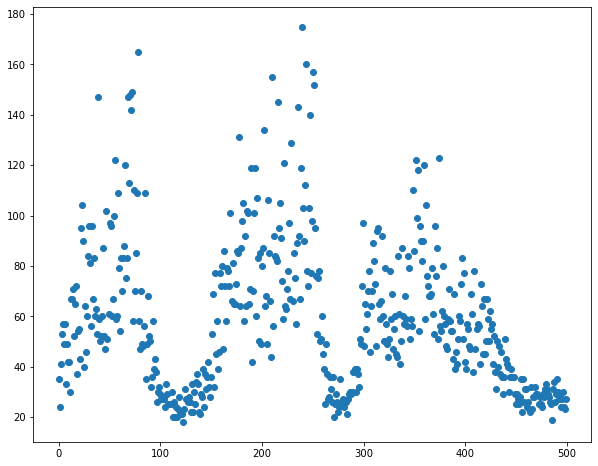

In [70]:
start_time = time.time()
MAX_ITERATION = 500
gamma = 0.99
acts = np.array([0, 1])

MAX_EPISODE = 30_000
MAX_ELIGIBILITY_VECTOR_SIZE = 10_000

for _ in range(MAX_ITERATION):
    # Play CartPole
    prob_batch = []
    state = env.reset()
    steps, done, truncated = 0, False, False
    
    try:
        while not done:
            act_prob = policy(torch.as_tensor(state).unsqueeze(0)).squeeze(0)
            act = np.random.choice(acts, p=act_prob.data.numpy())
            state, reward, done, info  = env.step(act)
            prob_batch.append(act_prob[act])
            steps += 1
            truncated = info.get('TimeLimit.truncated', False)
            if MAX_EPISODE <= steps:
                interrupted = ask_bool('Episode length exceeds {}. Do you want to stop?'.format(steps))
                if interrupted:
                    raise KeyboardInterrupt()
                    
        if len(prob_batch) >= MAX_ELIGIBILITY_VECTOR_SIZE:
            interrupted = ask_bool('Length of eligibility vector is {}. Do you want to reinforce?'.format(len(prob_batch)))
            if interrupted:
                raise KeyboardInterrupt()
    except KeyboardInterrupt:
        del prob_batch
        print('Interruped')
        break
    
    scores.append(steps)
    
    # Backpropagation
    prob_batch = torch.stack(prob_batch, dim=0)
    reward_batch = torch.arange(steps, 0, step=-1)
    disc_returns = torch.pow(gamma, torch.arange(steps, dtype=torch.float64)) * reward_batch
    disc_returns /= torch.max(disc_returns)
    loss = torch.sum(-1 * disc_returns * torch.log(prob_batch))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    del prob_batch

elapsed_time = time.time() - start_time
print('elapsed time = {}m {}s'.format(int(elapsed_time // 60), int(round(elapsed_time % 60, 0))))

plt.figure(figsize=(10, 8))
plt.scatter(np.arange(len(scores)), scores)
plt.show()

In [60]:
cartpole.sim(policy, env, limit=None, skip=1000, animation=True, terminal=True)

In [61]:
checkpoint = {
    'policy': policy.state_dict(),
    'optimizer': optimizer.state_dict(),
}
torch.save(checkpoint, '##NAME##')